In [2]:
from wilds import get_dataset
import open_clip
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
from util import *
import random

## Load model and dataset

In [34]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='openai')
tokenizer = open_clip.get_tokenizer('ViT-B-32')
device = "cuda"
model = model.to(device)
random.seed(123)

## Compute image embeddings

In [35]:
dataset = get_dataset(dataset="waterbirds", download=True)

# Load the training and test data
train_data = dataset.get_subset('train')
test_data = dataset.get_subset('test')
test_loader = DataLoader(
    test_data, 
    batch_size=32, 
    shuffle=False, 
    num_workers=8,
    collate_fn=lambda batch: (
        torch.stack([preprocess(img) for img, _, _ in batch]),  # inputs
        torch.tensor([label for _, label, _ in batch]),  # labels
        torch.tensor([torch.argmax(attr).item() for _, _, attr in batch])  # land_water_attributes
    )
    )
num_images = len(test_data)
embedding_dim = model.visual.output_dim 

# Tensors to store embeddings, labels, and land_water attributes
all_image_features = torch.empty((num_images, embedding_dim), dtype=torch.float32, device=device)
all_labels = torch.empty((num_images,), dtype=torch.long, device=device)
all_land_water_attributes = torch.empty((num_images,), dtype=torch.long, device=device)  # Store attribute as long tensor

start_idx = 0

for inputs, labels, land_water_attributes in tqdm(test_loader):
    # Move the inputs, labels, and land_water attributes to the correct device (GPU in this case)
    inputs = inputs.to(device)
    labels = labels.to(device)
    land_water_attributes = land_water_attributes.to(device)

    with torch.no_grad():
        # Encode the images to get their embeddings
        image_features = model.encode_image(inputs)  # (batch_size, 512)
        image_features = image_features.to(dtype=torch.float32, device=device)

    # Store the batch embeddings, labels, and land_water attributes in the preallocated tensors
    end_idx = start_idx + image_features.size(0)
    all_image_features[start_idx:end_idx] = image_features
    all_labels[start_idx:end_idx] = labels
    all_land_water_attributes[start_idx:end_idx] = land_water_attributes
    start_idx = end_idx

# After looping through all batches
print("All image features shape:", all_image_features.shape)
print("All labels shape:", all_labels.shape)
print("All land/water attributes shape:", all_land_water_attributes.shape)

  0%|          | 0/182 [00:00<?, ?it/s]

100%|██████████| 182/182 [00:05<00:00, 36.25it/s]

All image features shape: torch.Size([5794, 512])
All labels shape: torch.Size([5794])
All land/water attributes shape: torch.Size([5794])


In [4]:
torch.save(all_image_features, '../computed_embeddings/waterbirds_img_features_vit-b-32.pt')

## concept decomposition

In [5]:
# Convert tensor to NumPy array
all_image_features = all_image_features.to('cpu').numpy()
random.seed(1234)
k = 50
L = glaplacian(all_image_features)
U, S, Vt = randomized_svd(L, n_components=k)
S_diag = np.diag(S)
Z = U @ S_diag
Z_rotated, Rz = varimax_with_rotation(Z)
sign_Z = np.diag(np.where(np.mean(Z_rotated**3, axis=0) >= 0, 1, -1))
Z_hat = Z_rotated @ sign_Z
Y_hat = sign_Z @ Rz.T @ Vt
loadings = torch.tensor(Z_hat)

In [6]:
top_indices, top_scores = get_top_n_elements(csr_matrix(Z_hat.T), n=25)

## generate text descriptions
- Here we generate descriptions with template: A {bird} with a {background} background.

In [7]:
# Define the path to the text file
file_path = 'data/waterbirds_v1.0/class_label.txt'

# Initialize an empty list to store bird names
bird_names = []

# Open and read the file
with open(file_path, 'r') as file:
    # Iterate over each line in the file
    for line in file:
        # Split the line by the dot to separate the index and the bird name
        parts = line.strip().split('.')
        
        if len(parts) == 2:
            # Take the bird name part and replace underscores with spaces
            bird_name = parts[1].replace('_', ' ')
            # Remove any leading numbers or extra spaces and add it to the list
            bird_names.append(bird_name.strip())

In [8]:
backgrounds = ['bamboo forest', 'broadleaf forest', 'ocean', 'natural lake']

In [9]:
text_descriptions = []
# Generate the template for each bird type with each background type
for bird in bird_names:
    for background in backgrounds:
        description = f"A {bird} with a {background} background."
        text_descriptions.append(description)

In [10]:
text_inputs = tokenizer(text_descriptions).to(device)  # Tokenize batch
with torch.no_grad():
    all_text_embeddings = model.encode_text(text_inputs).to(device)

In [11]:
torch.save(all_text_embeddings, '../computed_embeddings/waterbirds_txt_embeddings_vit-b-32.pt')

In [12]:
projected_text = all_text_embeddings.to('cpu') @ Y_hat.T

In [13]:
top_text_indices, top_text_scores = get_top_n_elements(csr_matrix(projected_text), n=25, axis=0)

In [14]:
def has_various_types_of_birds_same_background(descriptions):
    bird_set = set()
    common_background = None

    for description in descriptions:
        # Split description into bird and background parts
        parts = description.split(" with a ")
        bird = parts[0][2:]  # Get the bird name (removing leading "A ")
        background = parts[1].split(" background")[0]

        # If common_background is not set, initialize it with the first background
        if common_background is None:
            common_background = background
        elif common_background != background:
            # If there's a different background, return False
            return False

        # Add the bird to the set of birds
        bird_set.add(bird)

    # Check if there are at least 25 different types of birds
    return len(bird_set) >= 25

res = []
spurious_concept_idx = []

for i in range(50):
# Example usage
    descriptions = [
        text_descriptions[j] for j in top_text_indices[i]
    ]
    result = has_various_types_of_birds_same_background(descriptions)
    res.append(result)
    if result:
        spurious_concept_idx.append(i)
print('Spurious concepts: ', spurious_concept_idx)

Spurious concepts:  [1, 2, 4, 6, 12, 15, 27]


## zs prediction

### Load metadata (water/land background)

In [16]:
# Ensure the metadata is collected as a tensor and moved to the GPU in the data loader
metadata_loader = DataLoader(
    test_data,
    batch_size=32,
    shuffle=False,
    collate_fn=lambda batch: torch.stack([attr.to(device) for _, _, attr in batch])  # Move attributes to GPU
)

all_metadata = []

# Collect the metadata batches and concatenate them
for metadata_batch in metadata_loader:
    all_metadata.append(metadata_batch)
# Concatenate all metadata batches into a single tensor
all_metadata_stacked = torch.cat(all_metadata, dim=0).to(device)  # Ensure all stacked metadata is on the GPU

### ZS

In [17]:
all_labels = all_labels.to('cuda:0')
class_names = ['a landbird', 'a waterbird'] 
text_inputs = tokenizer(class_names).to(device)  # Tokenize batch
with torch.no_grad():
    text_embeddings = model.encode_text(text_inputs).to(device)
all_image_features = torch.tensor(all_image_features).to(device)
original_pred = all_image_features@text_embeddings.T
preds = original_pred.argmax(dim=-1)
correct = (preds == all_labels).sum().item()
total = all_labels.size(0)
accuracy = correct / total
print(accuracy)
preds = preds.to('cpu')
all_labels = all_labels.to('cpu')
all_metadata_stacked = all_metadata_stacked.to('cpu')
_, results_str = dataset.eval(preds, all_labels, all_metadata_stacked)
print(results_str)

0.6658612357611322
Adjusted average acc: 0.848
  y =  landbird, background =  land  [n =   2255]:	acc = 0.839
  y =  landbird, background = water  [n =   2255]:	acc = 0.381
  y = waterbird, background =  land  [n =    642]:	acc = 0.760
  y = waterbird, background = water  [n =    642]:	acc = 0.963
Worst-group acc: 0.381



### Reconstructed embedding

In [21]:
reconstructed = torch.tensor(Z_hat @ Y_hat).to(device)
reconstructed = reconstructed.to(torch.float)
recons_preds = reconstructed @ text_embeddings.T
recons_preds = recons_preds.argmax(dim=-1)
all_labels = torch.tensor(all_labels).to(device)
correct = (recons_preds == all_labels).sum().item()
total = all_labels.size(0)
accuracy = correct / total
print(accuracy)
recons_preds = recons_preds.to('cpu')
all_labels = all_labels.to('cpu')
_, results_str = dataset.eval(recons_preds, all_labels, all_metadata_stacked)
print(results_str)

0.6748360372799448
Adjusted average acc: 0.854
  y =  landbird, background =  land  [n =   2255]:	acc = 0.847
  y =  landbird, background = water  [n =   2255]:	acc = 0.389
  y = waterbird, background =  land  [n =    642]:	acc = 0.787
  y = waterbird, background = water  [n =    642]:	acc = 0.961
Worst-group acc: 0.389



/tmp/ipykernel_769920/221522699.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_labels = torch.tensor(all_labels).to(device)


## After removing spurious concepts

In [18]:
Z_mask = Z_hat.copy()
cols_to_ablate = spurious_concept_idx
Z_mask[:, cols_to_ablate] = 0
reconstructed = torch.tensor(Z_mask @ Y_hat).to(device)
reconstructed = reconstructed.to(torch.float)
recons_preds = reconstructed @ text_embeddings.T
recons_preds = recons_preds.argmax(dim=-1)
all_labels = torch.tensor(all_labels).to(device)
correct = (recons_preds == all_labels).sum().item()
total = all_labels.size(0)
accuracy = correct / total
print(accuracy)
recons_preds = recons_preds.to('cpu')
all_labels = all_labels.to('cpu')
_, results_str = dataset.eval(recons_preds, all_labels, all_metadata_stacked)
print(results_str)

0.7623403520883673
Adjusted average acc: 0.891
  y =  landbird, background =  land  [n =   2255]:	acc = 0.903
  y =  landbird, background = water  [n =   2255]:	acc = 0.597
  y = waterbird, background =  land  [n =    642]:	acc = 0.698
  y = waterbird, background = water  [n =    642]:	acc = 0.914
Worst-group acc: 0.597



/tmp/ipykernel_782909/3812249175.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  all_labels = torch.tensor(all_labels).to(device)


## Visualize concept and text descriptions

### Visualize single concept

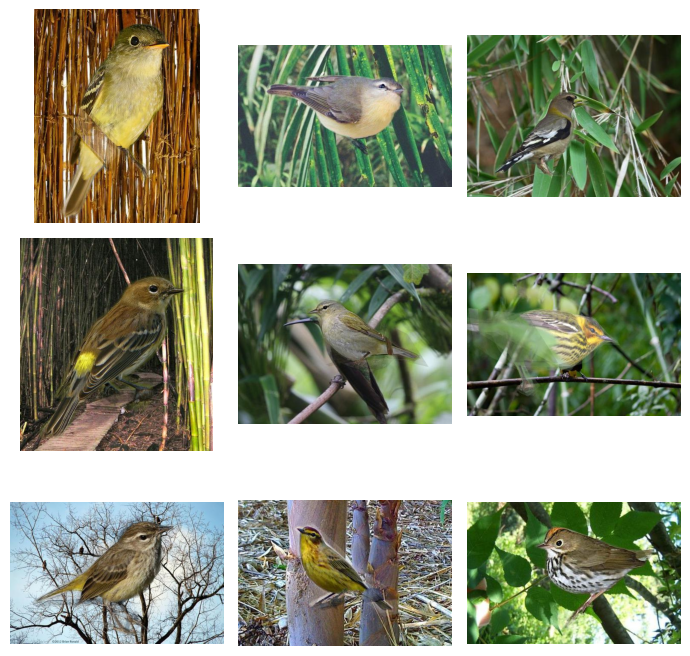

A Least Flycatcher with a bamboo forest background.
A Least Flycatcher with a broadleaf forest background.
A Least Flycatcher with a natural lake background.
A Acadian Flycatcher with a broadleaf forest background.
A Palm Warbler with a bamboo forest background.
A Acadian Flycatcher with a bamboo forest background.


In [141]:
concept_idx = 0
show_images_grid(top_indices[concept_idx], test_data)
for i in top_text_indices[concept_idx][:6]:
    print(text_descriptions[i])

### Visualize batch concepts

In [139]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

def show_images_and_text(top_indices, top_text_indices, dataset, text_descriptions):
    """
    Displays images and corresponding text descriptions for multiple concepts in a 2x3 grid.
    
    Args:
    top_indices (list of lists): A list where each element is a list of image indices for a concept.
    top_text_indices (list of lists): A list where each element is a list of text indices for a concept.
    dataset (Dataset): The dataset containing images.
    text_descriptions (list): List of text descriptions.
    """
    # Increase the figure size to make subplots larger
    fig = plt.figure(figsize=(25, 18))
    # Reduce spacing between subplots to maximize subplot area
    outer = GridSpec(2, 3, figure=fig, wspace=0.15, hspace=0.1)
    
    for concept_idx in range(6):
        # Adjust height ratios to give more space to images
        inner = GridSpecFromSubplotSpec(
            4, 3, 
            subplot_spec=outer[concept_idx], 
            hspace=0.05,
            height_ratios=[1, 1, 1, 0.5]  # Make the text row shorter
        )
        
        # Display images in a 3x3 grid (first 3 rows)
        for i in range(9):
            row = i // 3
            col = i % 3
            ax = fig.add_subplot(inner[row, col])
            idx = top_indices[concept_idx][i]
            img = dataset[idx][0]  # Assuming the image is at index 0
            ax.imshow(img)
            ax.axis('off')
        
        # Add text descriptions in the last row, spanning all columns
        ax_text = fig.add_subplot(inner[3, :])
        descriptions = [text_descriptions[i] for i in top_text_indices[concept_idx][:6]]
        ax_text.text(
            0.5, 0.5, '\n'.join(descriptions), 
            ha='center', va='center', wrap=True, fontsize=12
        )
        ax_text.axis('off')
        
    plt.savefig('waterbirds_concepts.png', dpi=150, bbox_inches='tight', pad_inches=0)

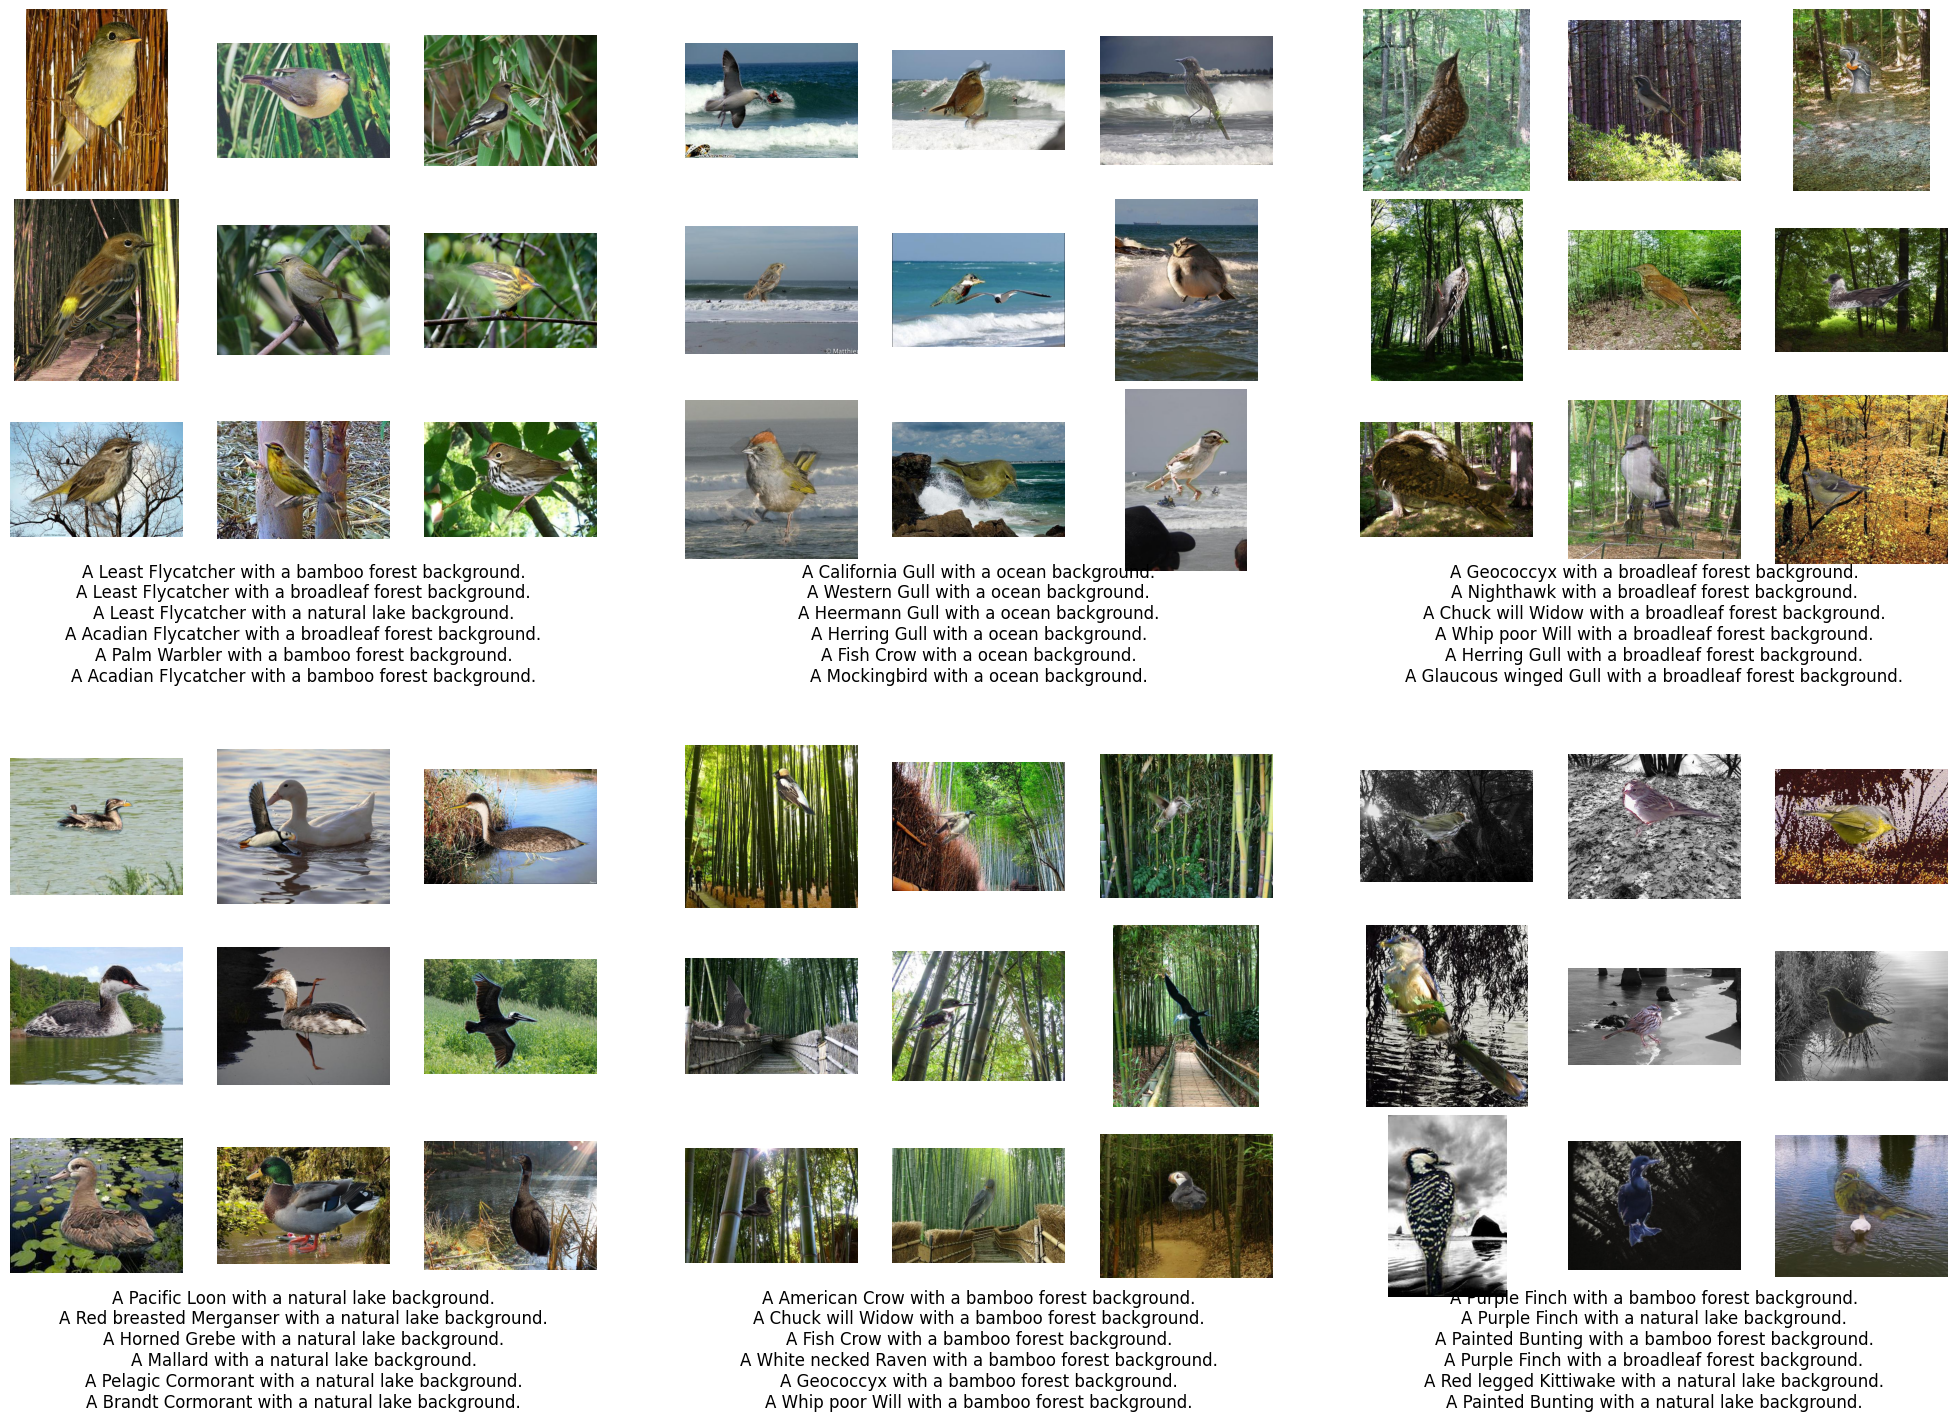

In [140]:
show_images_and_text(top_indices, top_text_indices, test_data, text_descriptions)